# Volatility Models: GARCH

This notebook estimates different GARCH models.

As an alternative, consider the [ARCHModels.jl](https://github.com/s-broda/ARCHModels.jl) package.

## Load Packages and Extra Functions

This notebook uses likelihood functions from the `FinEcmt_TimeSeries` module and then calls on the `MLE()` function from the `FinEcmt_MLEGMM` module. You may want to look at the MLE notebook before the current one.

In [1]:
MyModulePath = joinpath(pwd(),"src")
!in(MyModulePath,LOAD_PATH) && push!(LOAD_PATH,MyModulePath)
using FinEcmt_OLS, FinEcmt_TimeSeries
using FinEcmt_MLEGMM: MLE

[ Info: Precompiling FinEcmt_TimeSeries [top-level] (cache misses: include_dependency fsize change (2))


In [2]:
#=
include(joinpath(pwd(),"src","FinEcmt_OLS.jl"))
include(joinpath(pwd(),"src","FinEcmt_TimeSeries.jl"))
include(joinpath(pwd(),"src","FinEcmt_MLEGMM.jl"))
using .FinEcmt_OLS, .FinEcmt_TimeSeries
using .FinEcmt_MLEGMM: MLE
=#

In [3]:
using Dates, DelimitedFiles, Statistics, LinearAlgebra

In [4]:
using Plots
default(size = (480,320),fmt = :png)

## Loading Data

In [5]:
xx  = readdlm("Data/FFdSizePs.csv",',',skipstart=1)
ymd = round.(Int,xx[:,1])     #YearMonthDay, like 20121231
R   = xx[:,2]                 #returns for the smallest size portfolio
xx  = nothing

y = R[2:end]                           #dependent variable, y(t)
x = [ones(size(y)) R[1:end-1]]         #regressors, [1, y(t-1)]

dN = Date.(string.(ymd),"yyyymmdd");    #to Julia dates

# AR(1) + GARCH(1,1) Model

The next cells estimate an AR(1) where the residuals follow a different GARCH models. The results are used to calculate a time-varying (daily) value at risk and time-varying correlations.

## The Likelihood Function

Consider a regression equation, where the residual follows a GARCH(1,1) process

$y_{t}             =x_{t}^{\prime}b+u_{t} \: \text{ with }\: u_{t}=v_{t}\sigma_{t} \: \text{ and }$

$\sigma_{t}^{2}    =\omega+\alpha u_{t-1}^{2}+\beta\sigma_{t-1}^{2}.$

Notice that we require $(\omega,\alpha,\beta)$ to all be positive and $\alpha + \beta < 1$.

If $v_{t}\sim N(0,1)$, then the likelihood function is $\sum_{t=1}^{T} \ln L_t$ where

$\ln L_t= \ln \phi(u_{t}/\sigma_{t}) - \ln \sigma_{t}.$

The likelihood function of a GARCH(1,1) model is in `garch11LL`.

### A Remark on the Code

- For simplicity, the $\sigma_t^2$ is calculated in a loop. As an alternative, consider the `filt()` function from the [DSP.jl](https://github.com/JuliaDSP/DSP.jl) package.
- the code is in `src/Garch.jl`. The next cell prints the loglikelihood function.

In [6]:
@doc2 garch11LL

```
garch11LL(par,y,x)
```

Calculate `(LL_t,σ²,yhat,u)` for regression `y = x'b + u` where `u` follows a GARCH(1,1) process with paramaters `(ω,α,β)`.

### Input

  * `par::Vector`:  parameters, `[b;ω;α;β]`
  * `y::VecOrMat`:   Tx1, dependent variable
  * `x::VecOrMat`:   Txk, regressors


In [7]:
#using CodeTracking
#println(@code_string garch11LL([1],[1] [1]))    #print the source code

## Try the GARCH(1,1) Likelihood Function

...just to see that it delivers something.

In [8]:
par0      = [mean(y),0,var(y)*0.05,0.05,0.90]    #initial guess of b0,b1,ω,α,beta
(LLt,) = garch11LL(par0,y,x)                     #trying the log lik

printlnPs("Value of log-likelihood fn at starting guess of the parameters: ",sum(LLt))

Value of log-likelihood fn at starting guess of the parameters:  -9231.913


## Maximize the GARCH(1,1) Likelihood Function

by using the `MLE()` function from the `FinEcmt_MLEGMM` module. It wants at least four inputs: (`LLfunction,startingGuess,y,x`), but can also accept lower and upper bounds on the estimated parameters.

In [9]:
lower = [-Inf,-0.99, 0,0,0]        #upper and lower bounds on the parameters: b0,b1,ω,α,beta
upper = [ Inf, 0.99,10,1,1]

garch11LL_(par,y,x) = garch11LL(par,y,x)[1]     #to get a function with just one output as MLE wants
(parHat,std_hess,std_grad,std_sandw) = MLE(garch11LL_,par0,y,x,lower,upper)

printblue("point estimates and standard errors:\n")
coefNames = ["b₀","b₁","ω","α","β"]
xx = [parHat std_hess std_grad std_sandw]
printmat(xx;colNames=["estimate","std (InfoMat)","std (gradients)","std (sandwich)"],rowNames=coefNames,width=16)

point estimates and standard errors:

          estimate   std (InfoMat) std (gradients)  std (sandwich)
b₀           0.049           0.006           0.006           0.007
b₁           0.256           0.012           0.012           0.013
ω            0.014           0.001           0.001           0.003
α            0.162           0.009           0.005           0.020
β            0.824           0.009           0.005           0.019



## Value at Risk from GARCH(1,1)

calculated by assuming conditional (time-varying) normality,

$\text{VaR} = -(\mu_t - 1.645 \sigma_t),$

where 
$\mu_t$ are the predictions from the estimated mean equation ($x_t'b$) and $\sigma_t$ from the GARCH(1,1) model.

The fitted values of $\mu_t$ and $\sigma_t$ are calculated by calling `garch11LL(parHat,y,x)`, that is, using the point estimates and the data in the likelihood function. The outputs are `(LL_t,σ²,yhat,u,v),` so we need the 2nd and 3rd.

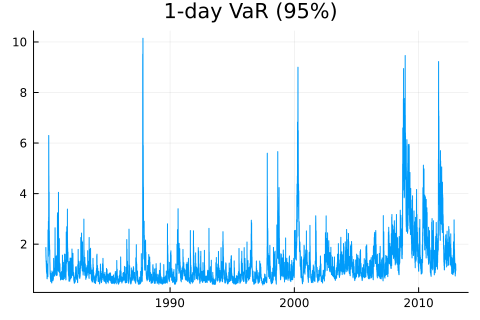

In [10]:
(σ²,μ) = garch11LL(parHat,y,x)[2:3]         #get the fitted values of the σ²- and μ-vectors
VaR95  = -(μ - 1.645*sqrt.(σ²))


xTicksLoc = [Date(1990),Date(2000),Date(2010)]
xTicksLab = Dates.format.(xTicksLoc,"Y")

p1 = plot( dN[2:end],VaR95,
           xticks = (xTicksLoc,xTicksLab),
           legend = false,
           title = "1-day VaR (95%)" )
display(p1)

In [11]:
CovRatio = mean((-y) .>= VaR95)             #coverage ratio for VaR
printlnPs("Coverage ratio for VaR(95%): ",CovRatio)

Coverage ratio for VaR(95%):      0.058


# eGARCH(1,1)

This section estimates an eGARCH model.

The structure of the likelihood function `egarch11LL()` is similar to `garch11LL()` used before.

In [12]:
# @doc2 egarch11LL

In [13]:
#using CodeTracking
#println(@code_string egarch11LL([1],[1],[1]))    #print the source code

## Estimate an eGARCH(1,1) model

In [14]:
par0 = [mean(y),0,var(y)*0.05,0.05,0.90,0]   #initial parameter guess: b0,b1,ω,α,β,γ

lower = [-Inf,-0.99,-Inf,-Inf,0,-Inf]        #upper and lower bounds on the parameters
upper = [ Inf, 0.99, Inf, Inf,1, Inf]

egarch11LL_(par,y,x) = egarch11LL(par,y,x)[1]              #to get a function with just one output
(parHat,std_hess,std_grad,std_sandw) = MLE(egarch11LL_,par0,y,x,lower,upper)

printblue("eGARCH(1,1), parameter estimates\n")
coefNames = ["b₀","b₁","ω","α","β","γ"]
printmat(parHat,std_sandw;colNames=["coef","std (sandw)"],rowNames=coefNames)

eGARCH(1,1), parameter estimates

        coefstd (sandw)
b₀     0.043     0.004
b₁     0.266     0.010
ω     -0.231     0.024
α      0.272     0.027
β      0.969     0.006
γ     -0.062     0.013

